In [1]:
# 开始训练0-3的mnist模型
import torch 
import torchvision
from torchvision.datasets import mnist # 获取数据集和数据预处理
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from torch.utils.data import DataLoader

data_tf = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.5],[0.5])
    ]
)
data_path = '/home/.faa/data'
batch_size = 256
# 获取数据集
train_data = mnist.MNIST(data_path,train=True,transform=data_tf,download=True)
test_data = mnist.MNIST(data_path,train=False,transform=data_tf,download=True)
train_index = torch.zeros_like(train_data.targets)
test_index = torch.zeros_like(test_data.targets)
for i in range(4, 10):
    train_index |= train_data.targets == i
    test_index |= test_data.targets == i
train_loader_4to9 = DataLoader(Subset(train_data, torch.nonzero(train_index).reshape(-1)), batch_size=batch_size, shuffle=True)
test_loader_4to9 = DataLoader(Subset(test_data, torch.nonzero(test_index).reshape(-1)), batch_size=batch_size, shuffle=True)

In [2]:
# 这边需要把所有的类别都往后移4, 否则会报错

In [3]:
import torch.nn as nn#
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self, output_channel):
        super(CNN,self).__init__()
        self.conv1=nn.Conv2d(1,20,5,1)
        self.conv2=nn.Conv2d(20,50,5,1)
        self.fc1=nn.Linear(4*4*50,500)
        self.fc2=nn.Linear(500,output_channel)
    def forward(self,x):
        #x是一个batch_size的数据
        #x:1*28*28
        x=F.relu(self.conv1(x))
        #10*24*24
        x=F.max_pool2d(x,2,2)
        #10*12*12
        x=F.relu(self.conv2(x))
        #25*8*8
        x=F.max_pool2d(x,2,2)
        #25*4*4
        x=x.view(-1,50*4*4)
        #压扁成了行向量，(1,25*4*4)
        x=F.relu(self.fc1(x))
        #(1,500)
        x=self.fc2(x)
        #(1,10)
        return F.log_softmax(x,dim=1)   

In [4]:
old = torch.load('0-3_cnn.ckpt')

In [5]:
def train(model,device,train_loader,optimizer,epoch,losses):
    model.train()
    for idx,(t_data,t_target) in enumerate(train_loader):
        t_data,t_target=t_data.to(device),t_target.to(device)
        t_target -= 4
        pred=model(t_data)#batch_size*10
        loss=F.nll_loss(pred,t_target)

        #SGD
        optimizer.zero_grad()#将上一步的梯度清0
        loss.backward()#重新计算梯度
        optimizer.step()#更新参数
        if idx%20==0:
            print("epoch:{},iteration:{},loss:{}".format(epoch,idx,loss.item()))
            losses.append(loss.item()) 

def test(model,device,test_loader, epoch, acc):
    model.eval()
    correct=0#预测对了几个。
    num = 0
    with torch.no_grad():
        for idx,(t_data,t_target) in enumerate(test_loader):
            t_data,t_target=t_data.to(device),t_target.to(device)
            t_target -= 4
            pred=model(t_data)#batch_size*10
            pred_class=pred.argmax(dim=1)#batch_size*10->batch_size*1
            correct+=pred_class.eq(t_target.view_as(pred_class)).sum().item()
            num += len(t_target)
    acc=correct/num
    print("epoch:{},accuracy:{}".format(epoch, acc))
    test_acc.append(acc)

In [6]:
lr=0.005#学习率
momentum=0.5
device=torch.device("cuda")

model=CNN(6).to(device)

for i, (name, g) in enumerate(model.named_parameters()):
    old_g = old[name].data
    if old_g.shape != g.shape:
        print(old_g.shape, g.shape)
        new_g = torch.zeros_like(g)
        new_g[:old_g.shape[0]] = old_g
        g.data = new_g
    else:
        g.data = old[name].data


torch.Size([4, 500]) torch.Size([6, 500])
torch.Size([4]) torch.Size([6])


In [7]:
optimizer=optim.SGD(model.parameters(),lr=lr,momentum=momentum, weight_decay=0.01)
num_epochs=5
losses=[]#记录起来用来画图的，可以画出损失随着迭代次数而下降。
test_acc = []
from time import *
begin_time=time()#测试我们的模型训练要花多久。
for epoch in range(num_epochs):
    train(model,device,train_loader_4to9,optimizer,epoch,losses)
    test(model,device,test_loader_4to9, epoch, test_acc)
end_time=time()

epoch:0,iteration:0,loss:2.5712015628814697
epoch:0,iteration:20,loss:1.5335394144058228
epoch:0,iteration:40,loss:1.1052380800247192
epoch:0,iteration:60,loss:0.9336096048355103
epoch:0,iteration:80,loss:0.7402055263519287
epoch:0,iteration:100,loss:0.6308048963546753
epoch:0,iteration:120,loss:0.5866028070449829
epoch:0,accuracy:0.8415197672428547
epoch:1,iteration:0,loss:0.5359365344047546
epoch:1,iteration:20,loss:0.44767606258392334
epoch:1,iteration:40,loss:0.41009923815727234
epoch:1,iteration:60,loss:0.4394415020942688
epoch:1,iteration:80,loss:0.28694379329681396
epoch:1,iteration:100,loss:0.3158465623855591
epoch:1,iteration:120,loss:0.36843249201774597
epoch:1,accuracy:0.9029608078042102
epoch:2,iteration:0,loss:0.2841183841228485
epoch:2,iteration:20,loss:0.32301512360572815
epoch:2,iteration:40,loss:0.2277313619852066
epoch:2,iteration:60,loss:0.3680979013442993
epoch:2,iteration:80,loss:0.21082499623298645
epoch:2,iteration:100,loss:0.24795198440551758
epoch:2,iteration:1

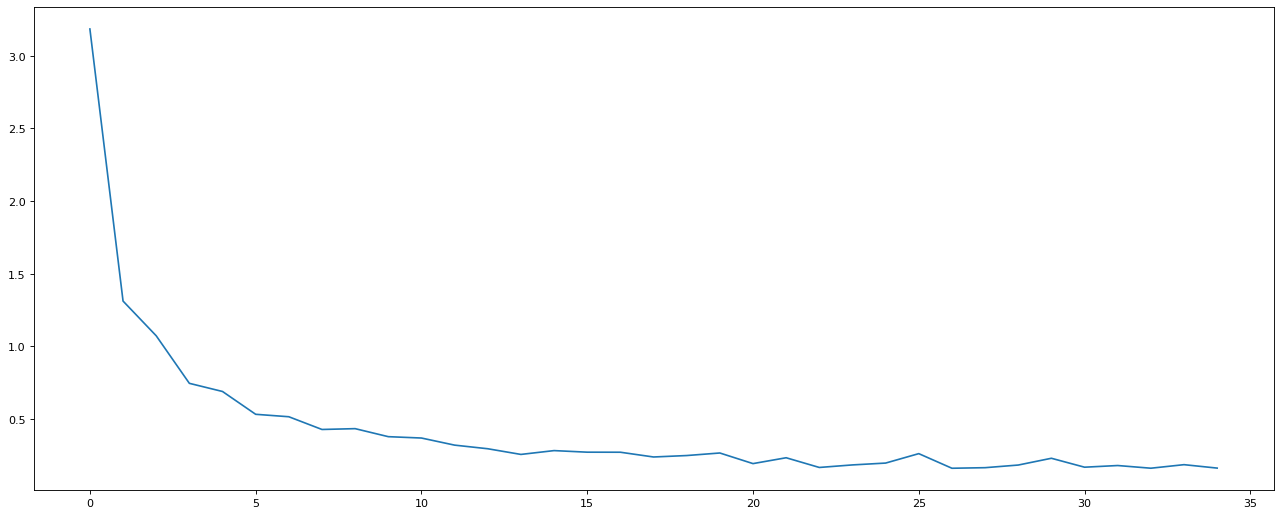

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
len_l=len(losses)
x=[i for i in range(len_l)]
figure=plt.figure(figsize=(20,8),dpi=80)
plt.plot(x,losses)
plt.show()

In [ ]:
torch.save(model.state_dict(), '4-6_cnn_surgery.ckpt')